In [1]:
# Import all necessary packages and the two datasets
# The first dataset is all fraudulent claims for q1 2023
# The second dataset is all claims for 2023 and includes the fraudulent ones
# Both datasets will be joined using the masked_claim_reference_number

###################################
# Step 1: Import and Load the Data
###################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

q1_fraud_df = pd.read_csv('datasets/2023_fraud_claims.csv')
claims_2023_df = pd.read_csv('datasets/2023_claims.csv')

claims_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653697 entries, 0 to 1653696
Data columns (total 32 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   masked_claim_reference_number  1653697 non-null  object 
 1   date_filled                    1653697 non-null  int64  
 2   claim_type                     1653697 non-null  object 
 3   customer_id                    1653697 non-null  int64  
 4   patient_paid_amount            0 non-null        float64
 5   copay_amount                   1653697 non-null  float64
 6   basis_of_reimbursement         1653697 non-null  object 
 7   refund                         1607527 non-null  object 
 8   transaction_status             1653697 non-null  object 
 9   masked_cardholder_id           1653697 non-null  object 
 10  age                            1653696 non-null  float64
 11  prescriber_id                  1653697 non-null  int64  
 12  prescriber_nam

In [2]:
##########################################
# Step 2: Merge and Create is_fraud Column
##########################################
merged_df = claims_2023_df.merge(
    q1_fraud_df[['masked_claim_reference_number']],
    on='masked_claim_reference_number',
    how='left',
    indicator=True
)

merged_df['is_fraud'] = np.where(merged_df['_merge'] == 'both', 1, 0)
merged_df.drop(columns=['_merge'], inplace=True)

In [3]:
#################################
# Step 3: Filter Q1 and Q2-Q4 Data
#################################
# Adjust dates as needed. Assuming date_filled is YYYYMMDD:
q1_data = merged_df[(merged_df['date_filled'] >= 20230101) & (merged_df['date_filled'] <= 20230331)]
q2_q4_data = merged_df[(merged_df['date_filled'] >= 20230401) & (merged_df['date_filled'] <= 20231231)]

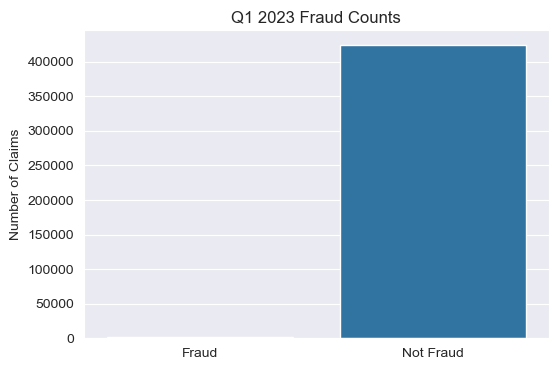

Q1 2023 Fraud Rate: 0.38%


In [4]:
##############################
# Step 4: Visualize Q1 Fraud Rate
##############################
q1_fraud_rate = q1_data['is_fraud'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=['Fraud', 'Not Fraud'],
            y=[q1_data['is_fraud'].sum(), (len(q1_data) - q1_data['is_fraud'].sum())])
plt.title('Q1 2023 Fraud Counts')
plt.ylabel('Number of Claims')
plt.show()

print("Q1 2023 Fraud Rate: {:.2f}%".format(q1_fraud_rate * 100))

In [5]:
#######################################
# Step 5: Prepare Data for Model Training
#######################################
# Q1 data for training
X_train = q1_data.drop(['is_fraud', 'masked_claim_reference_number'], axis=1)
y_train = q1_data['is_fraud']

# Q2-Q4 data for testing/prediction
X_test = q2_q4_data.drop(['is_fraud', 'masked_claim_reference_number'], axis=1)
y_test = q2_q4_data['is_fraud']  # If no known labels, this may just be placeholders

In [7]:
#######################################
# Step 6: Clean and Encode the Data
#######################################
# Drop columns with all null values
cols_to_drop = []
if 'patient_paid_amount' in X_train.columns and X_train['patient_paid_amount'].isnull().all():
    cols_to_drop.append('patient_paid_amount')
if 'pharmacy_type' in X_train.columns and X_train['pharmacy_type'].isnull().all():
    cols_to_drop.append('pharmacy_type')

X_train = X_train.drop(cols_to_drop, axis=1, errors='ignore')
X_test = X_test.drop(cols_to_drop, axis=1, errors='ignore')

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Fill missing categorical values
for col in categorical_cols:
    X_train[col] = X_train[col].fillna('Unknown')
    X_test[col] = X_test[col].fillna('Unknown')

# Label Encoding for categorical columns
le = LabelEncoder()
for col in categorical_cols:
    combined_categories = pd.concat([X_train[col], X_test[col]]).astype(str).unique().tolist()
    le.fit(combined_categories)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Fill numeric missing values
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

# Scale numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [8]:
###############################
# Step 7: Train the Model
###############################
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [9]:
####################################
# Step 8: Evaluate Model on Training
####################################
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:,1]

print("Training Set Metrics:")
print(classification_report(y_train, y_train_pred))
print("AUC Score (Train):", roc_auc_score(y_train, y_train_proba))

Training Set Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424152
           1       1.00      0.97      0.98      1599

    accuracy                           1.00    425751
   macro avg       1.00      0.98      0.99    425751
weighted avg       1.00      1.00      1.00    425751

AUC Score (Train): 0.9999999808321516


In [10]:
###############################################
# Step 9: Predict Fraud on Q2-Q4 with threshold
###############################################
y_test_proba = best_model.predict_proba(X_test)[:,1]
predicted_fraud = (y_test_proba >= 0.7).astype(int)

In [11]:
##########################################
# Step 10: Evaluate on Q2-Q4 if Labels Exist
##########################################
# Only evaluate if we have known labels in y_test
if y_test.nunique() > 1:
    print("Q2-Q4 Test Set Metrics:")
    print(classification_report(y_test, predicted_fraud))
    print("AUC Score (Test):", roc_auc_score(y_test, y_test_proba))

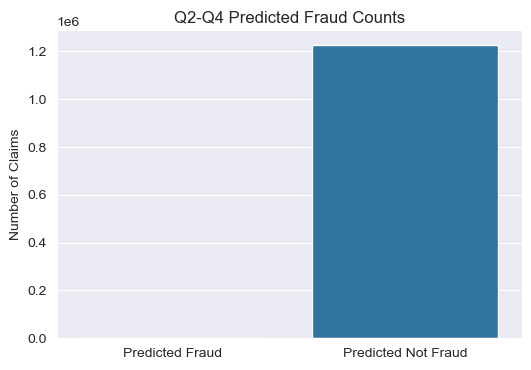

Q2-Q4 Predicted Fraud Rate: 0.11%


In [12]:
###############################
# Step 11: Visualize Q2-Q4 Results
###############################
predicted_fraud_rate = predicted_fraud.mean()

plt.figure(figsize=(6,4))
sns.barplot(x=['Predicted Fraud', 'Predicted Not Fraud'],
            y=[predicted_fraud.sum(), len(predicted_fraud)-predicted_fraud.sum()])
plt.title('Q2-Q4 Predicted Fraud Counts')
plt.ylabel('Number of Claims')
plt.show()

print("Q2-Q4 Predicted Fraud Rate: {:.2f}%".format(predicted_fraud_rate * 100))

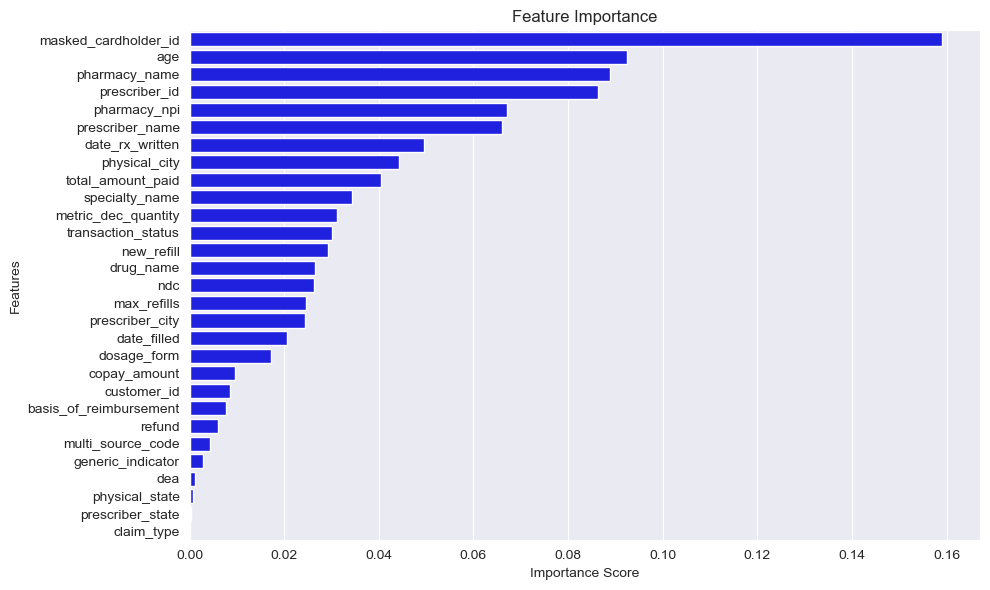

In [14]:
#####################################
# Step 12: Feature Importance Plot
#####################################
importances = best_model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, color='blue')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()